### LoopFlopy Example 3 - Adding Heterogeneity

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
for module in modules: 
    print(module)

c:\users\00105295\projects\loopflopy\loopflopy\__init__.py
dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel_routines
mesh
mesh_routines
modelling_routines_old
observations
project
spatial
spatial_routines
structuralmodel
surfacerefinement
utils


### 1. Setup Project

In [2]:
# Project setup
name = 'example'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)

### 2. Spatial

In [3]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
spatial.x0, spatial.x1, spatial.y0, spatial.y1

(349088.0373017123, 392718.4692868978, 6507368.199997337, 6546515.9098643325)

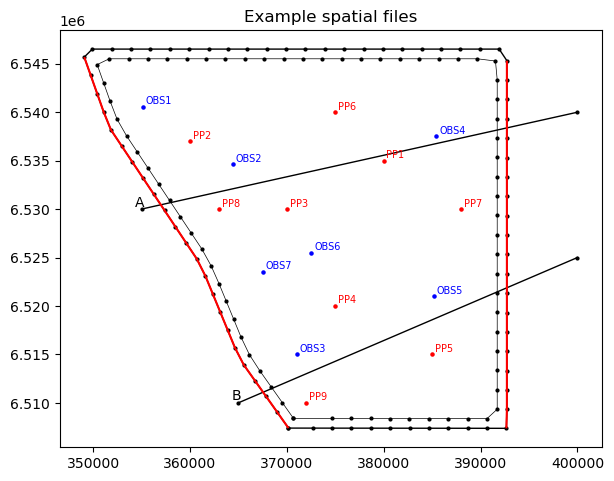

In [4]:
process_spatial.obs_bores(spatial)
process_spatial.geo_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.pilot_points(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)

spatial.xsection_names = ['A', 'B']
spatial.xsections = [[(355000, 6530000),(400000, 6540000)], [(365000, 6510000),(400000, 6525000)]]
process_spatial.plot_spatial(spatial, 
                             obsbores = True, 
                             pilotpoints = True,
                             pumpbores = False, 
                             geobores = False, 
                             xsections = True, 
                             fault = False)

In [5]:
# Create a map
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=10, popup = 'ID')
spatial.model_boundary_gdf.explore(m=m, fill = False)
#spatial.faults_gdf.explore(m=m, color = 'red')
spatial.pumpbore_gdf.explore(m=m, color = 'red', popup = 'ID')

### 3. Structural Model

In [6]:
# Create Structural Model
geodata_fname = '../data/example_data.xlsx'
data_sheetname = 'geo_bores'
strat_sheetname = 'strat'
bbox = [(348000, 6500000, -1000), (400000, 6550000, 500)] #[(x0, y0, z0), (x1, y1, z1)]
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(spatial, bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial, Fault = False)
process_structural.create_structuralmodel(structuralmodel, Fault = False)

structuralmodel.faults = ['Fault']

1.6.11


C:\Users\00105295\AppData\Roaming\Python\Python312\site-packages\LoopStructural\modelling\core\geological_model.py:648: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [7]:
structuralmodel.data

,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz,data_type
0,OBS1,355120.0,6540562,31.0,0,Ground,Ground,0,0,1,Raw
1,OBS1,355120.0,6540562,1.0,5,TQ,TQ,0,0,1,Raw
2,OBS1,355120.0,6540562,-174.0,-174,Kcok,Kcok,0,0,1,Raw
3,OBS1,355120.0,6540562,-307.0,-184,Kwlp,Leed,0,0,1,Raw
4,OBS2,364415.7,6534636,27.0,0,Ground,Ground,0,0,1,Raw
5,OBS2,364415.7,6534636,-8.0,5,TQ,TQ,0,0,1,Raw
6,OBS2,364415.7,6534636,-183.0,-174,Kcok,Kcok,0,0,1,Raw
7,OBS2,364415.7,6534636,-313.0,-184,Kwlp,Leed,0,0,1,Raw
8,OBS3,371000.0,6515000,46.0,0,Ground,Ground,0,0,1,Raw
9,OBS3,371000.0,6515000,11.0,5,TQ,TQ,0,0,1,Raw


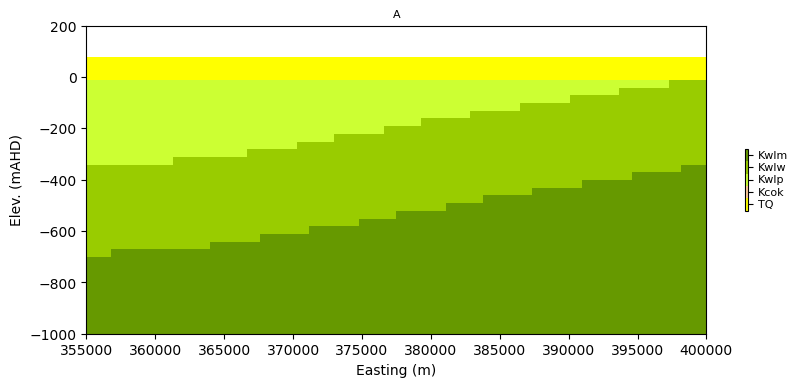

<Figure size 640x480 with 0 Axes>

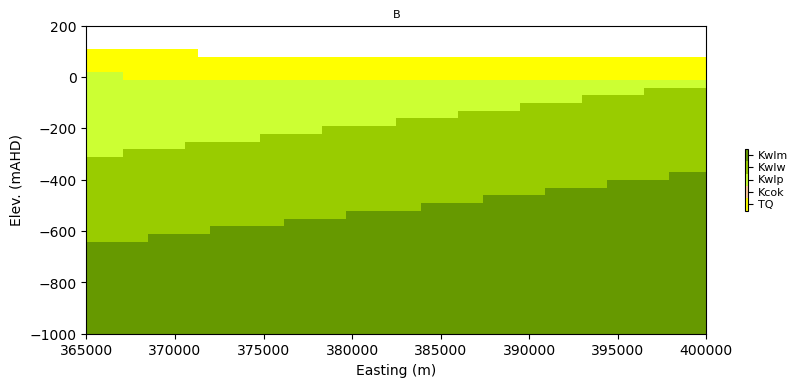

<Figure size 640x480 with 0 Axes>

In [8]:
z0 = -1000 # just for plotting. Make sure within bbox of structural model
z1 = 200   # just for plotting. Make sure within bbox of structural model
nh, nz = 50, 40 # plotting resolution

for i in range(len(spatial.xsections)):
    start = spatial.xsections[i][0]
    end   = spatial.xsections[i][1]

    structuralmodel.plot_xytransect(title = spatial.xsection_names[i], start = start, end = end, z0 = z0, z1 = z1, nh = nh, nz = nz)

In [9]:
def evaluate_model(structuralmodel, start, end, z0, z1, nh, nz, **kwargs):

    x0 = start[0]
    y0 = start[1]
    x1 = end[0]
    y1 = end[1]

    x = np.linspace(x0, x1, nh)
    y = np.linspace(y0, y1, nh)        
    z = np.linspace(z0, z1, nz)

    X = np.tile(x, (len(z), 1)) 
    Y = np.tile(y, (len(z), 1)) 
    Z = np.tile(z[:, np.newaxis], (1, nh))  # Repeat z along columns (nh times)

    labels = structuralmodel.strat_names[1:]
    ticks = [i for i in np.arange(0,len(labels))]
    boundaries = np.arange(-1,len(labels),1)+0.5

    a = np.array([X.flatten(),Y.flatten(),Z.flatten()]).T
    V = structuralmodel.model.evaluate_model(a).reshape(np.shape(X))

    return V

i = 0 # first transect
start = spatial.xsections[i][0]
end   = spatial.xsections[i][1]
nh, nz = 50, 50
V = evaluate_model(structuralmodel, start, end, z0, z1, nh, nz)
np.unique(V.flatten(), return_counts=True)

(array([-1,  0,  2,  3,  4]), array([250, 199, 364, 714, 973]))

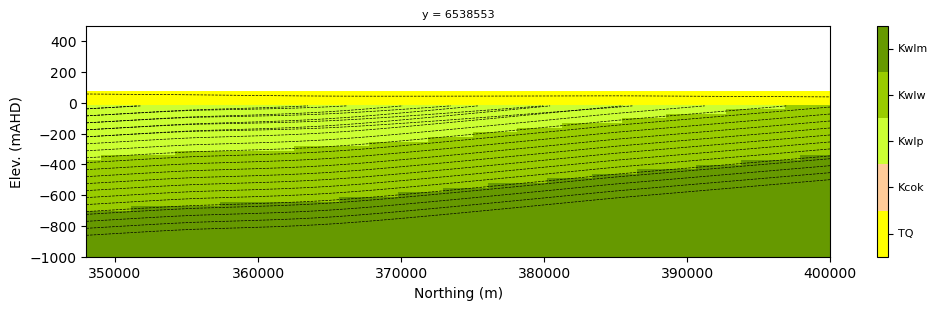

In [10]:
transect_y = [6538553] 
structuralmodel.plot_ytransects2(transect_y, nx = 50, nz = 50, dz = 50)#, faults = False,
#structuralmodel.plot_ytransects(transect_y, nx = 50, nz = 50)#, z0 = -1200, z1 = 200) 


#structuralmodel.strat_col 
#structuralmodel.strat_names 
#structuralmodel.cmap
#structuralmodel.norm 
#structuralmodel.data

### 4. Meshing

In [11]:
# Create mesh object
from loopflopy.mesh import Mesh
special_cells = {
                 'chd': ['east', 'west'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'], 
                 }
mesh = Mesh(plangrid = 'tri', special_cells = special_cells) # special cells to identify as arguements 

In [12]:
# Define mesh parameters and create mesh
mesh.modelmaxtri = 1000000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 400 # 50, 200 radius of inner circle around pumping bores
mesh.radius2 = 800 # 200, 600 radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['bore_refinement_nodes']#['fault_nodes', 'bore_refinement_nodes',]
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

bore_refinement_nodes
number of cells in plan =  2291


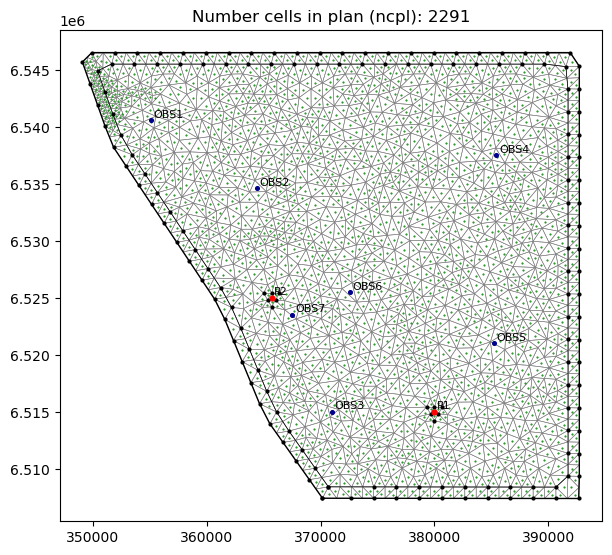

In [13]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

features = ['wel', 'obs']#,'river']
mesh.plot_cell2d(spatial, features, xlim = xlim, ylim = ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['east', 'west']
chd_east_cells [196 323 205 201 318 198 315 207 321 200 319 324 209 325 224 333 214 334
 216 327 211 328 223 330 212 331 221 229 337 220 335 339 239 340 306 342
 244 343 269 276 355 274 353 345 268 346 283 348 271 349 278 351 272 352
 281 302 358 285 356 366 292 367 294 360 287 361 301 363 289 364 296 290
 370 368 299]
chd_west_cells [51 47 1993 1991 42 831 36 827 39 38 1998 41 1994 70 2279 2277 60 54 2220
 61 7 2061 6 10 1210 9 8 974 4 0 3 2 25 1999 24 1404 1400 27 26 2120 29
 2118 17 2101 16 2097 2262 20 2260 18 1612 21 1608 150 1607 83 1605 82
 2211 86 2209 85 84 2045 80 912 909 910 903 908 899 902 890 893 887 889
 878 883 874 877 865 868 862 864 95 914 861 94 921 105]
Group =  wel ['pumpbores']
Group =  obs ['obsbores']


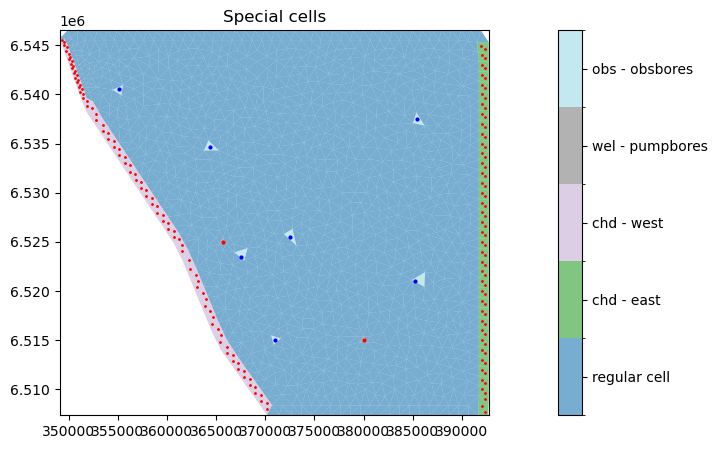

In [14]:
# Locate special cells and plot
mesh.locate_special_cells(spatial)

xlim = [355000, 370000]
ylim = [6525000, 6535000]

mesh.plot_feature_cells(spatial, xlim = None, ylim = None)

### 5. Geomodel

In [15]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -1000, 200 

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 2, res = 3) # surfaces calculated at a 3m resolution

geomodel.evaluate_structuralmodel(mesh, structuralmodel)
geomodel.create_model_layers(mesh, structuralmodel)

geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)

   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  1.939438
   1. Evaluating structural model...
len(xyz) =  916400
Time taken Block 1 (Evaluate model) =  12.273584
   2. Creating geo model layers...
stop_array shape (6, 2291)
nlay =  400
ncpl =  2291
nlg number of geo layers =  5
ICPL =  0
line 225 stop  [399]
ICPL =  1
line 225 stop  [399]
ICPL =  2
line 225 stop  [399]
ICPL =  3
line 225 stop  [399]
ICPL =  4
line 225 stop  [399]
ICPL =  5
line 225 stop  [399]
ICPL =  6
line 225 stop  [399]
ICPL =  7
line 225 stop  [399]
ICPL =  8
line 225 stop  [399]
ICPL =  9
line 225 stop  [399]
ICPL =  10
line 225 stop  [399]
ICPL =  11
line 225 stop  [399]
ICPL =  12
line 225 stop  [399]
ICPL =  13
line 225 stop  [399]
ICPL =  14
line 225 stop  [399]
ICPL =  15
line 225 stop  [399]
ICPL =  16
line 225 stop  [399]
ICPL =  17
line 225 stop  [399]
ICPL =  18
line 225 stop  [399]
ICPL =  19
line 225 stop  [399]
ICPL =  20
line 225 stop  [399]
ICPL =  21
line 225 stop  [399]
ICPL

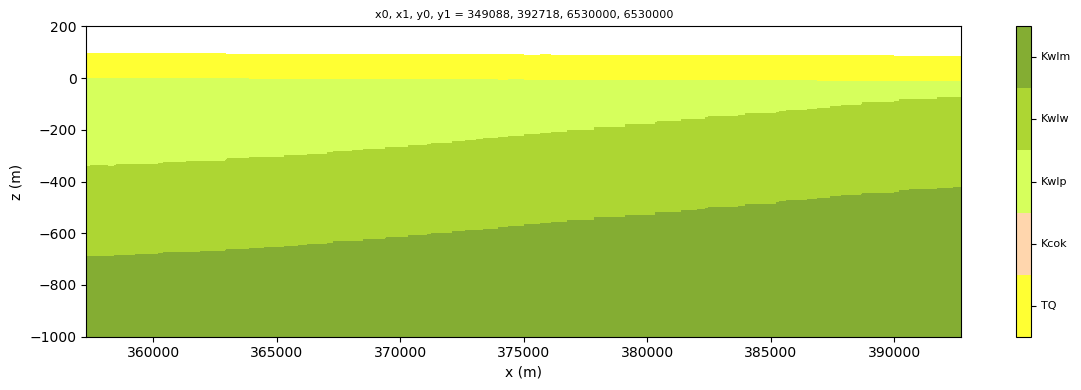

In [16]:
y0, y1 = 6530000, 6530000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1)# z0 = -200, z1 = 300

### Create heterogenous field

In [17]:
from process_properties import Properties
properties = Properties()
properties.create_properties(mesh, structuralmodel, geomodel)
%run C:\Users\00105295\Projects\Lab_tools\Geostats_tools\Krigger.py

hello


#### Processing observations

In [18]:
def processing_obs(spatial, geomodel, mesh):

    import math
    from shapely.geometry import Point

    gi = flopy.utils.GridIntersect(geomodel.vgrid)
    geomodel.zcenters = geomodel.botm + geomodel.thick/2
    
    xobs = spatial.obsbore_gdf.Easting.tolist()
    yobs = spatial.obsbore_gdf.Northing.tolist()
    zobs = spatial.obsbore_gdf.zobs.tolist()
    kobs = spatial.obsbore_gdf.kh.tolist()
    
    points_values = list(zip(xobs, yobs, zobs, np.log10(kobs)))

    obs_cell_info = []
    celldisv_prop = []
    
    for i in range(len(xobs)):
        print(spatial.idobsbores[i])
        x,y,z = xobs[i], yobs[i], zobs[i]
        icpl = mesh.gi.intersect(Point(x,y))["cellids"][0]
 
        zarray = geomodel.zcenters[:, icpl] # get pillar z values
        lay = np.abs(zarray - z).argmin()   # find nearest layer
        cell_disv = icpl + lay*mesh.ncpl
        cell_disu = utils.disvcell_to_disucell(geomodel, cell_disv)
        X = mesh.xcyc[icpl][0]
        Y = mesh.xcyc[icpl][1]
        Z = geomodel.zcenters[lay, icpl]

        celldisv_prop.append((cell_disv, kobs[i]))
    
        obs_cell_info.append([spatial.idobsbores[i], # obs id
                              (x, y, z),             # obs coordinates   
                              mesh.obs_cells[i],     # cell id in mesh
                              cell_disv,             # cell id in disv grid
                              cell_disu,             # cell id in disu grid
                              (X, Y, Z),
                              kobs[i]])            # cell xyz coordinates
              
    return points_values, obs_cell_info, np.array(celldisv_prop)


points_values, obs_cell_info, celldisv_prop = processing_obs(spatial, geomodel, mesh)
points_values_3d = np.array(points_values)


OBS3
OBS5
OBS7
OBS6
OBS2
OBS4
OBS1


#### 2D K Field

In [19]:
def plot_kfield(mesh, spatial, k_values, xlim = None, ylim = None): # e.g xlim = [700000, 707500]
    
    from matplotlib import gridspec

    fig = plt.figure(figsize=(7,5))
    spec = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 0.05], wspace=0.2)

    ax = fig.add_subplot(spec[0], aspect="equal") #plt.subplot(1, 1, 1, aspect="auto")
    if xlim: ax.set_xlim(xlim) 
    if ylim: ax.set_ylim(ylim) 
    ax.set_title('Kfield')
        
    pmv = flopy.plot.PlotMapView(ax = ax, modelgrid=mesh.vgrid)   
    mask = mesh.idomain == 0
    ma = np.ma.masked_where(mask, k_values)
    p = pmv.plot_array(ma, alpha = 0.6, cmap = 'Spectral')#, norm = norm)  

    gdf = spatial.pilotpoint_gdf[spatial.pilotpoint_gdf.Unit == 'TQ']
    gdf.plot(ax=ax, markersize = 5, color = 'red', zorder=2)
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.ID):
        ax.annotate(label, xy=(x, y), xytext=(2, 2), size = 7, color = 'red', textcoords="offset points")

    spatial.obsbore_gdf.plot(ax=ax, markersize = 5, color = 'black', zorder=2)
    for x, y, label in zip(spatial.obsbore_gdf.geometry.x, spatial.obsbore_gdf.geometry.y, spatial.obsbore_gdf.ID):
        ax.annotate(label, xy=(x, y), xytext=(2, 2), size = 7, textcoords="offset points") 
   
    # Colorbar
    cbar_ax = fig.add_subplot(spec[1])
    cbar = fig.colorbar(p, cax=cbar_ax, shrink = 0.1)  # Center tick labels
    #plt.savefig('../figures/kfield.png')

(2291, 2)
(2291, 1)
(2291, 1)


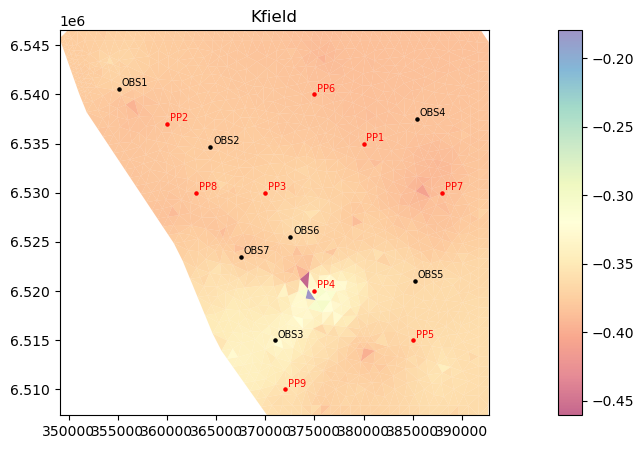

In [20]:
# 2D plot of K field

za = np.zeros(len(mesh.xcyc)).reshape(-1,1)
vals = np.full(len(mesh.xcyc), np.nan).reshape(-1,1)

print(mesh.xcyc.shape)
print(za.shape)
print(vals.shape)

points_values_3d = np.hstack((mesh.xcyc, za, vals))

random_values = optimized_kriging(points_values_3d, #x y z val USE LOG K
                  n_neighbors=6, # determines how many neighbours
                  variogram_model="spherical", 
                  CL = 100.,  # Correlation length
                  sill = 20,  # maximum variance
                  nugget = 0, # value at 0 distance
                  return_random=True, #False is kriging (deterministic), True is stochastoc
                  random_seed=None, 
                  n_initial_points=10, # doesnt use if existing points, number of points to sample for initial variogram (assuming all points are nan)
                  unknown_value_flag=np.nan, 
                  anisotropy=(1., 1., 1.),
                  rebuild_threshold=0.001) # how often to recreate KDTree e.g. every 0.1% of points rebuild KDTree


points_values_3d[:,-1][np.isnan(points_values_3d[:,-1])] = random_values
k_values = points_values_3d[:,-1]

plot_kfield(mesh, spatial, k_values)

#### 3D Kriging

In [28]:
df = pd.read_excel('../data/example_data.xlsx', sheet_name = 'pilot_points')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Easting, df.Northing), crs=spatial.epsg)
gi = flopy.utils.GridIntersect(geomodel.vgrid)
geomodel.zcenters = geomodel.botm + geomodel.thick/2
units = np.array(structuralmodel.strat_names[1:])  

# Perform the intersection
gdf['logmean_kh']  = gdf['mean_kh'].apply(lambda kh: np.log10(kh))  
gdf['icpl']      = gdf['geometry'].apply(lambda point: mesh.gi.intersect(point)["cellids"][0])
gdf['ppcell_xy'] = gdf['icpl'].apply(lambda icpl: (mesh.xcyc[icpl][0], mesh.xcyc[icpl][1]))
gdf['geolay']    = gdf['Unit'].apply(lambda Unit: np.where(units == Unit)[0][0]) # Find the index of the strat name in the list
gdf['lay']       = gdf['geolay'].apply(lambda geolay: geomodel.nls * geolay)                                                            
gdf['cell_disv'] = gdf.apply(lambda row: row['icpl'] + row['lay'] * mesh.ncpl, axis=1)  
gdf['cell_disu'] = gdf.apply(lambda row: utils.disvcell_to_disucell(geomodel, row['cell_disv']), axis=1)  
gdf['ppcell_z']  = gdf.apply(lambda row: geomodel.zcenters[row['lay'], row['icpl']], axis=1)

# Calculate sill
sills = []
for unit in units: # for each unit...
    unit_gdf = gdf[gdf.Unit == unit]
    sill = np.abs(np.mean(unit_gdf.logmean_kh.values)) 
    sills.append(sill)
    gdf.loc[gdf.Unit == unit, 'sill'] = sill # assign sill to all points in unit

pp_gdf = gdf[gdf['cell_disu'] != -1] # delete pilot points where layer is pinched out

In [29]:
#pp_gdf

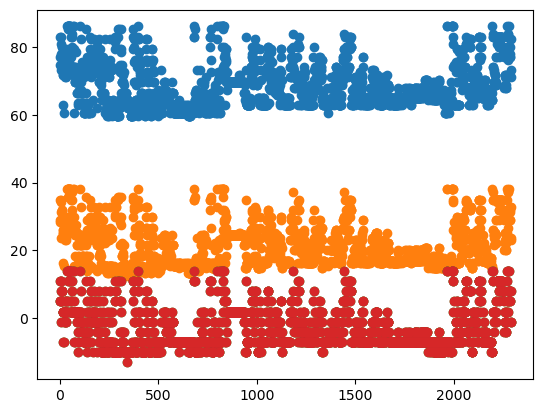

In [30]:
plt.plot(geomodel.zcenters[0], 'o')
plt.plot(geomodel.zcenters[1], 'o')
plt.plot(geomodel.zcenters[2], 'o')
plt.plot(geomodel.zcenters[3], 'o')

In [31]:
## MAKE AN ARRAY OF X,Y,Z,VAL
import math

current_disucell = 0
k_values_layicpl = 999999 * np.ones((geomodel.nlay, geomodel.ncpl))

for geolay, unit in enumerate(units): # for each unit...

    gdf = pp_gdf[pp_gdf.Unit == unit]
    pv = []

    for icpl in range(geomodel.ncpl): # for each cell in plan...
        for sublay in range(geomodel.nls): # for each sublayer in unit..
            lay = geolay * geomodel.nls + sublay # Zero based
            disvcell = icpl + lay*geomodel.ncpl
            
            if geomodel.idomain[lay, icpl] == 1: # only include cells not pinched out #### CAUTION 
                x = mesh.xcyc[icpl][0]
                y = mesh.xcyc[icpl][1]
                z = geomodel.zcenters[lay, icpl]

                if disvcell in gdf.cell_disv.values:    # check if cell is a pilot point cell
                    id = gdf.loc[gdf['cell_disv'] == disvcell, 'ID'].values[0]
                    val = np.log10(gdf.loc[gdf['cell_disv'] == disvcell, 'mean_kh'].values)[0]
                    print(id, unit, 'disv_cell', disvcell, 'val', val)
        
                else:
                    val = np.nan        
                    
                pv.append([x, y, z, val])
    points_values_3d = np.array(pv)

    #plt.plot(points_values_3d[:,0], points_values_3d[:,1], 'o', markersize = 2, color = 'black', alpha = 0.5)
    #plt.show()
    #plt.plot(points_values_3d[:, 2], 'o')
    #plt.show()
    #plt.plot(points_values_3d[:, 3], 'o')
    #plt.show()

    print('sill ', sills[geolay])
    ## RUN KRIGING
    random_values = optimized_kriging(points_values_3d, #x y z val USE LOG K
                    n_neighbors = 10, # determines how many neighbours
                    variogram_model="spherical", 
                    CL = 1000.,  # Correlation length
                    sill = sills[geolay],  # maximum variance - replace with spreadsheet
                    nugget = 0, # value at 0 distance
                    return_random = False, #False is kriging (deterministic), True is stochastoc
                    random_seed = None, 
                    #n_initial_points=10, # doesnt use if existing points, number of points to sample for initial variogram (assuming all points are nan)
                    unknown_value_flag=np.nan, 
                    anisotropy=(1., 1., 0.01),
                    rebuild_threshold=0.1) # how often to recreate KDTree e.g. every 0.1% of points rebuild KDTree'''

    points_values_3d[:,-1][np.isnan(points_values_3d[:,-1])] = random_values
    k_values = points_values_3d[:,-1]
    print('k_values ', k_values.shape)

    k_values = k_values.reshape(geomodel.nls, geomodel.ncpl) # reshape into layers
    print('k_values ', k_values.shape)

    for sublay in range(geomodel.nls):
        lay = geolay * geomodel.nls + sublay # Zero based
        k_values_layicpl[lay,:] = k_values[sublay, :] # assign to the correct layer in the disv grid

ma = np.ma.masked_where(k_values_layicpl == 999999, k_values_layicpl)

# Reshape into DISV (lay, icpl) format

#    for disucell in range(len(k_values)):
#        lay, icpl = utils.disucell_to_layicpl(geomodel, disucell)
#        k_values_layicpl[lay, icpl] = k_values[disucell]
#        current_disucell += 1


PP9 TQ disv_cell 40 val 1.0
PP8 TQ disv_cell 789 val 1.0
PP7 TQ disv_cell 1009 val 1.0
PP5 TQ disv_cell 1086 val 1.0
PP6 TQ disv_cell 1343 val 1.0
PP3 TQ disv_cell 1385 val 1.0
PP4 TQ disv_cell 1458 val 2.0
PP2 TQ disv_cell 1535 val 0.6989700043360189
PP1 TQ disv_cell 1671 val 1.0
sill  1.0776633338151131


IndexError: index 9 is out of bounds for axis 0 with size 9

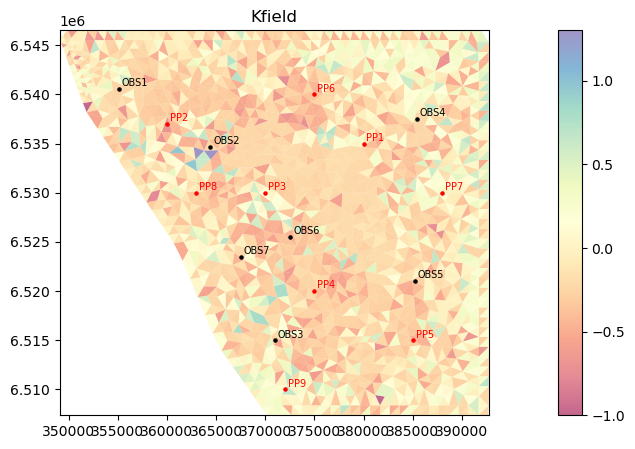

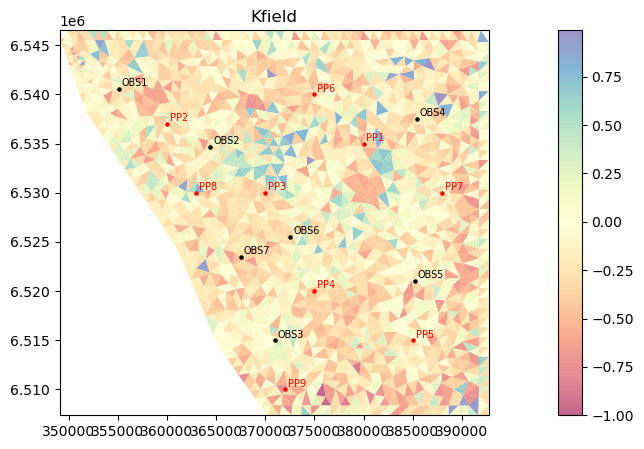

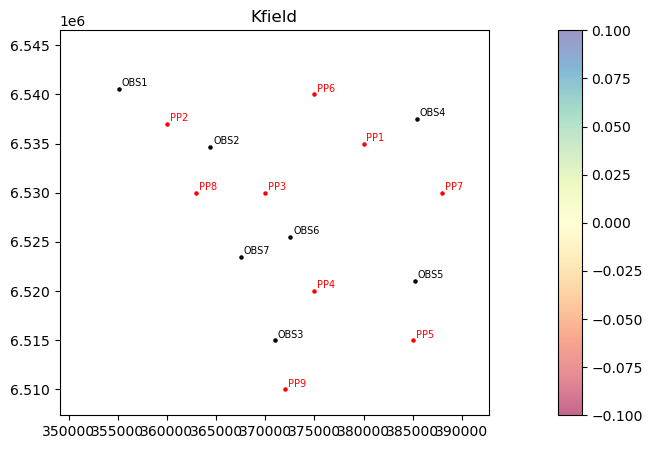

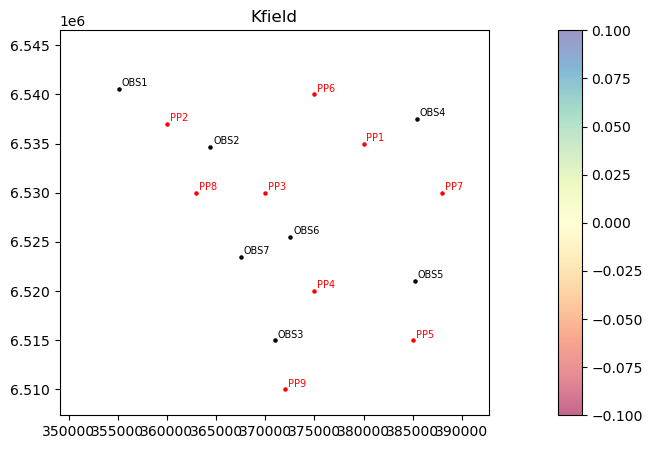

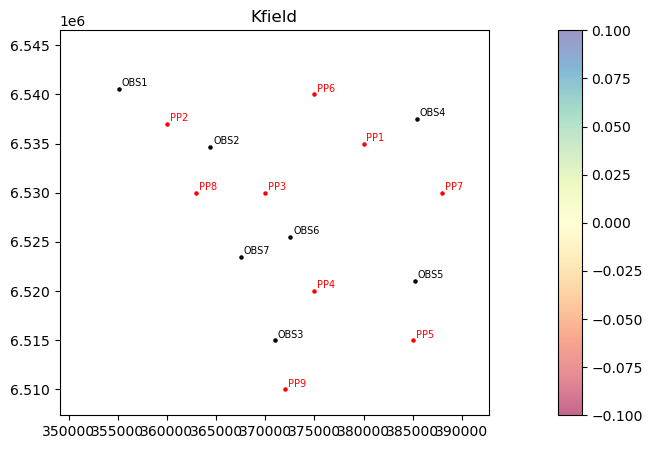

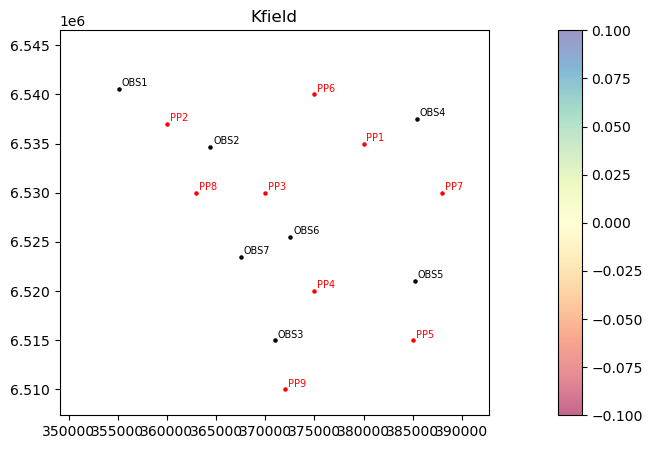

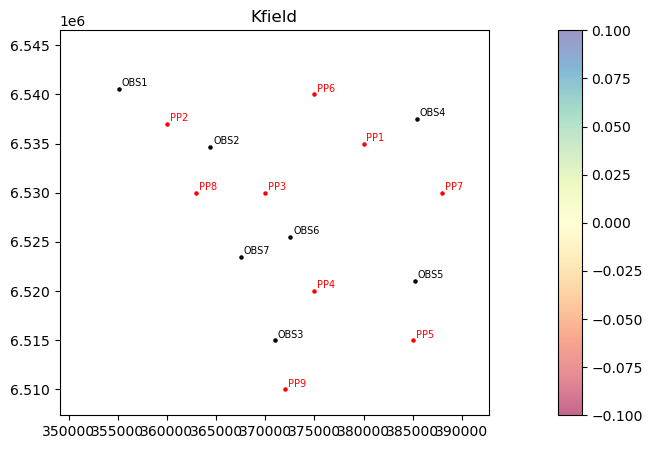

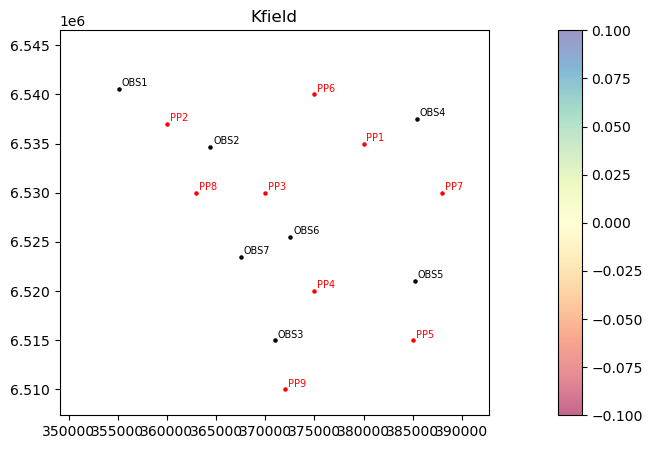

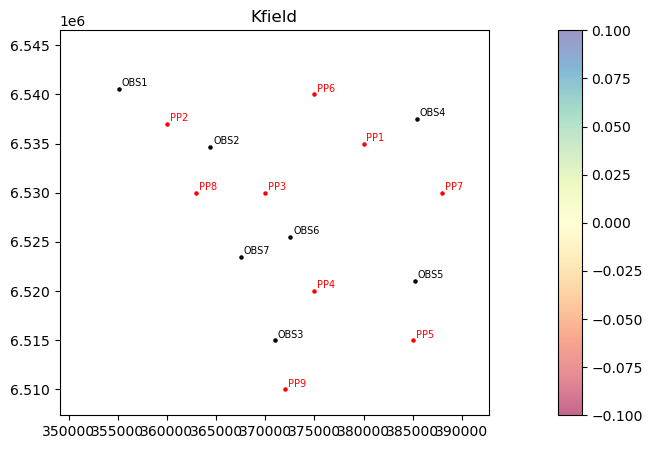

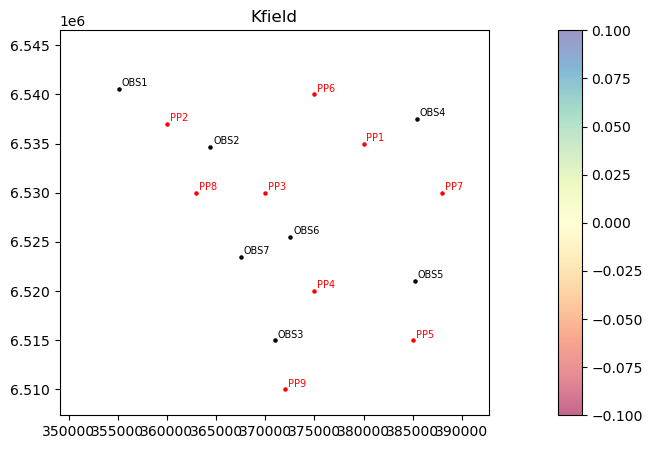

In [ ]:
for lay in range(10):    
    plot_kfield(mesh, spatial, ma[lay])

In [ ]:
#print(celldisv_prop)
for i, cell in enumerate(obs_cells_disv):
    print(celldisv_prop[i])
    lay, icpl = utils.disvcell_to_layicpl(geomodel, cell)
    print(ma[lay, icpl])



NameError: name 'obs_cells_disv' is not defined

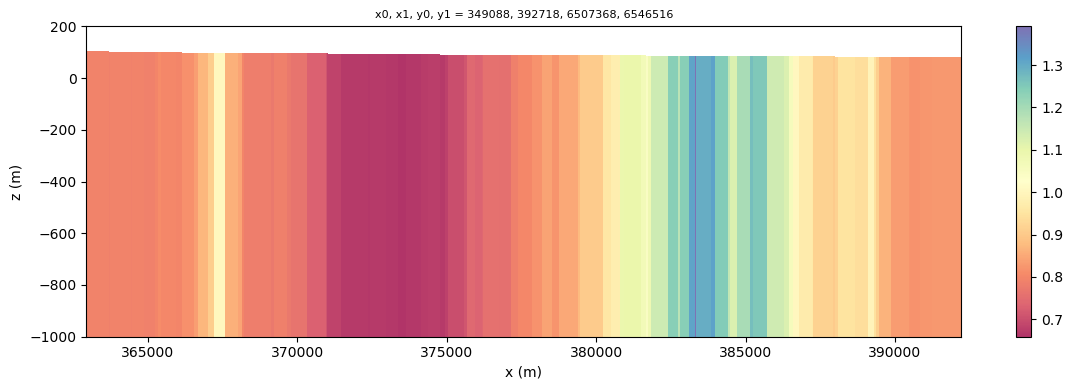

In [ ]:
def plot_kfield_usg(geomodel, spatial, x0, x1, y0, y1, **kwargs):
    x0 = kwargs.get('x0', spatial.x0)
    y0 = kwargs.get('y0', spatial.y0)
    z0 = kwargs.get('z0', geomodel.z0)
    x1 = kwargs.get('x1', spatial.x1)
    y1 = kwargs.get('y1', spatial.y1)
    z1 = kwargs.get('z1', geomodel.z1)

    fig = plt.figure(figsize = (12,4))
    ax = plt.subplot(111)
    xsect = flopy.plot.PlotCrossSection(modelgrid=geomodel.vgrid , line={"line": [(x0, y0),(x1, y1)]}, geographic_coords=True)
    csa = xsect.plot_array(a = ma, cmap = 'Spectral', alpha=0.8)
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    ax.set_ylim([z0, z1])
    #linecollection = xsect.plot_grid(lw = 0.1, color = 'black') # Don't plot grid for reference
    
    cbar = plt.colorbar(csa,shrink = 1.0)
    plt.title(f"x0, x1, y0, y1 = {x0:.0f}, {x1:.0f}, {y0:.0f}, {y1:.0f}", size=8)
    plt.tight_layout()  
    plt.savefig('../figures/usg_kfield.png')
    plt.show()   

#spatial.xsections = [[(355000, 6530000),(400000, 6540000)], [(365000, 6510000),(400000, 6525000)]]
x0, x1, y0, y1 = spatial.xsections[0][0][0], spatial.xsections[0][1][0], spatial.xsections[0][0][1], spatial.xsections[0][1][1]
plot_kfield_usg(geomodel, spatial, x0, x1, y0, y1)

In [ ]:
# 1. Make 10 points per layer
#2. Give each of those points a K value (sample from log mean K distibution)
#3. Use kriging to interpolate K values for all cells in the model
values = optimized_kriging(points_values_3d, #x y z val USE LOG K
                  n_neighbors=10, # determines how many neighbours
                  variogram_model="spherical", 
                  CL = 10.,  # Correlation length
                  sill = 1,  # maximum variance
                  nugget = 0, # value at 0 distance
                  return_random=False, #False is kriging (deterministic), True is stochastoc
                  random_seed=None, 
                  n_initial_points=10, # doesnt use if existing points, number of points to sample for initial variogram (assuming all points are nan)
                  unknown_value_flag=np.nan, 
                  anisotropy=None, #(x,y,z)
                  rebuild_threshold=0.001) # how often to recreate KDTree e.g. every 0.1% of points rebuild KDTree

In [ ]:
points_values_3d[:,-1][np.isnan(points_values_3d[:,-1])] = values
print("\nRandom values generated from Kriging (mean + variance) in original order:")
print(points_values_3d)
import pylab as plt


Random values generated from Kriging (mean + variance) in original order:
[[ 3.75001000e+05  6.51908700e+06 -1.00000000e+02  0.00000000e+00]
 [ 3.67502000e+05  6.52350000e+06 -5.00000000e+01  1.00000000e+00]
 [ 3.72541000e+05  6.52547800e+06 -1.00000000e+02  4.77121255e-01]
 [ 3.80000000e+05  6.53156600e+06 -1.00000000e+02  0.00000000e+00]
 [ 3.64415700e+05  6.53463600e+06 -5.00000000e+01  6.98970004e-01]
 [ 3.81250000e+05  6.53810000e+06 -1.00000000e+02  1.00000000e+00]]


In [ ]:
plt.imshow(points_values_3d[:,-1].reshape(5,40,40)[2,:,:],vmin=-2.5,vmax=2.5)
plt.show()

print(np.mean(points_values_3d[:,-1]), np.var(points_values_3d[:,-1]))

In [ ]:
dir(geomodel)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'ang1',
 'ang2',
 'botm',
 'botm_geo',
 'create_model_layers',
 'dz',
 'evaluate_structuralmodel',
 'fill_cell_properties',
 'geomodel_plan_lith',
 'geomodel_transect_lith',
 'get_surface_lith',
 'idomain',
 'idomain_geo',
 'lith',
 'lith_disv',
 'litho',
 'model_layers',
 'nlay',
 'nlg',
 'nls',
 'nnodes_div',
 'res',
 'scenario',
 'strat_names',
 'thick',
 'thick_geo',
 'top_geo',
 'transect',
 'vertgrid',
 'vgrid',
 'xyz',
 'z0',
 'z1',
 'zc']

In [ ]:
# 1. Make 10 points per layer
#2. Give each of those points a K value (sample from log mean K distibution)
#3. Use kriging to interpolate K values for all cells in the model
optimized_kriging(points_values , #x y z val USE LOG K
                  n_neighbors=10, # determines how many neighbours
                  variogram_model="spherical", 
                  CL = 10.,  # Correlation length
                  sill = 1,  # maximum variance
                  nugget = 0, # value at 0 distance
                  return_random=False, #False is kriging (deterministic), True is stochastoc
                  random_seed=None, 
                  n_initial_points=10, # doesnt use if existing points, number of points to sample for initial variogram (assuming all points are nan)
                  unknown_value_flag=np.nan, 
                  anisotropy=None, #(x,y,z)
                  rebuild_threshold=0.001) # how often to recreate KDTree e.g. every 0.1% of points rebuild KDTree

In [ ]:
# LOG
k_min = [0, -2, 0, -2]
k_max = [1, -1, 1, -1]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]

print(k_min)
print(k_max)
print(k_mean)

Min.append(k_min[i+8]) 
Max.append(k_max[i+8])

(8000, 4)

Random values generated from Kriging (mean + variance) in original order:
[[ 1.          1.          1.          1.93899668]
 [ 2.          1.          1.          1.54228383]
 [ 3.          1.          1.          1.41998645]
 ...
 [38.         40.          5.         -0.16899305]
 [39.         40.          5.          0.70709775]
 [40.         40.          5.         -0.67400757]]


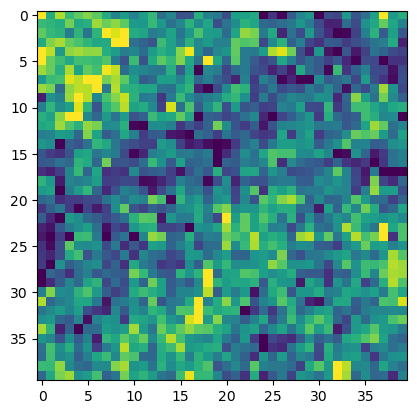

-0.21311219352527627 1.3582932237814598


In [ ]:
pv = []
for i in range(5):
    for j in range(40):
        for k in range(40): 
            pv.append([k+1,j+1,i+1,np.nan])


points_values_3d = np.array(pv)
print(points_values_3d.shape)

variogram_params = {'range': 5, 'sill': 1, 'nugget': 0.1}
anisotropy = (1, 1, 1.)

# Run Kriging
random_values = optimized_kriging(
    points_values_3d, n_neighbors=2, variogram_model="spherical", CL = 5.,return_random=True, anisotropy=anisotropy
)
points_values_3d[:,-1][np.isnan(points_values_3d[:,-1])] = random_values
print("\nRandom values generated from Kriging (mean + variance) in original order:")
print(points_values_3d)
import pylab as plt
plt.imshow(points_values_3d[:,-1].reshape(5,40,40)[2,:,:],vmin=-2.5,vmax=2.5)
plt.show()

print(np.mean(points_values_3d[:,-1]), np.var(points_values_3d[:,-1]))

hello


In [ ]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'properties')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = props.iconvert.tolist()
geomodel.fill_cell_properties(mesh)
props

   6. Filling cell properties...
ang1 shape  (10, 1156)
9248
angle1 shape  (9248,)
Time taken Block 6 Fill cell properties =  0.005804


,index,unit,hk,vk,ss,sy,iconvert
0,1,TQ,50.0,5.0,0.0001,0.1,1.0
1,2,Kcok,5.0,5.0,0.0001,0.1,0.0
2,3,Kwlp,50.0,50.0,0.0001,0.1,0.0
3,4,Kwlw,50.0,50.0,0.0001,0.1,0.0
4,5,Kwlm,100.0,100.0,0.0001,0.1,0.0


### 6. Prepare Data for Flowmodel

In [ ]:
from process_data import Data
data = Data()

data.process_ic()#geomodel)
data.process_rch(geomodel, mesh)
data.process_chd(spatial, geomodel, mesh)

wel_q = [-100000, 0]
wel_qlay= [0, 0]
data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)


Well screens  [(np.float64(-1000.0), np.float64(26.0)), (np.float64(-1000.0), np.float64(8.0))]


In [ ]:
from loopflopy.observations import Observations
observations = Observations(spatial.obsbore_gdf )
observations.process_obs(spatial, geomodel, mesh)

### 8. Create and run steady-state flow model

In [ ]:
from loopflopy.flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
xt3d =  True
   Time taken to write flow model =  3.875355
Running simulation for  steadymodel  ...
Model success =  True
   run_time =  4.806329
['DISU', 'NPF', 'IC', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 9248)


In [ ]:
utils.print_object_details(fm)

Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
chd
chdflow
data
geomodel
gwf
head
lith
logk11
logk33
mesh
newtonoptions
obs
obsdata
observations
project
rch
runtime
scenario
spd
staggered
wel
xt3d


Node one based =  1508 Node zero based =  1507
XYZ problem =  392385.13595356414 6533656.490388577 28.25
cell width approx  1000.0
cell length approx  1000.0
cell thickness 46.5
lay, icpl (1, 351)


AttributeError: 'Spatial' object has no attribute 'faults_gdf'

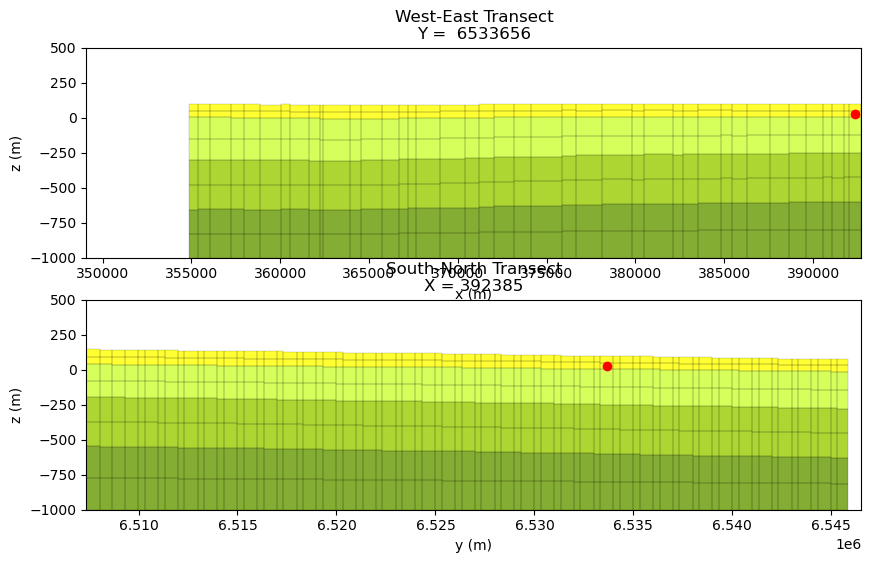

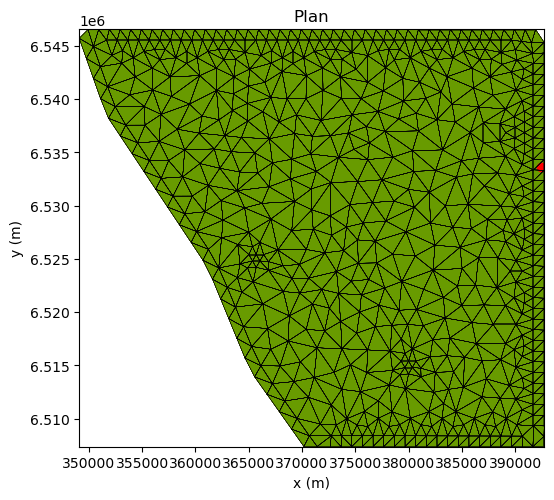

In [ ]:
# IF A PROBLEM NODE FROM MFSIM, CAN LOT LOCATION HERE!
utils.plot_node(1508-1, geomodel, structuralmodel, spatial, sim, scenario, z1 = 500, features = ['fault'])

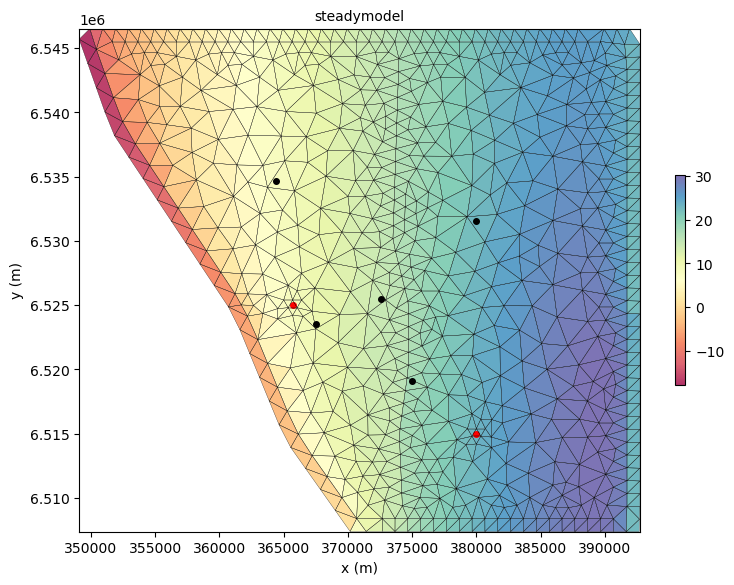

In [ ]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable,)#, extent, vmin, vmax

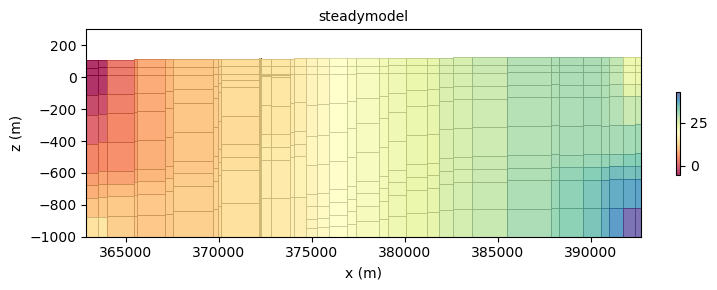

In [ ]:
fm.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)

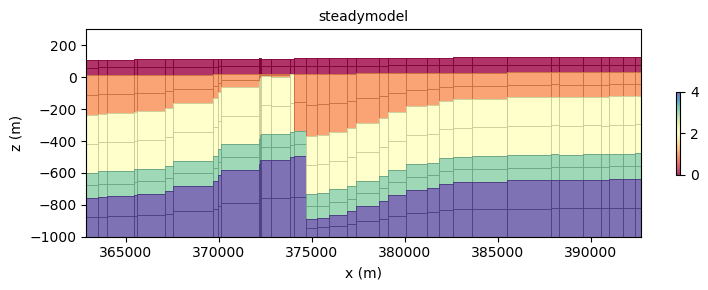

In [ ]:
fm.plot_transect(spatial, structuralmodel, 'lith', y0 = 6520000, y1 = 6520000)

In [ ]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

Methods in the class:   ['get_watertable', 'plot_plan', 'plot_transect', 'plot_watertable', 'run_flowmodel', 'write_flowmodel']

Attributes in the class:   ['chd', 'chdflow', 'data', 'geomodel', 'gwf', 'head', 'lith', 'logk11', 'logk33', 'mesh', 'newtonoptions', 'obs', 'obsdata', 'observations', 'project', 'rch', 'runtime', 'scenario', 'spd', 'staggered', 'wel', 'xt3d']


### 9. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fm.head
fm2 = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
fm2.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

Well screens  [(np.float64(-1000.0), np.float64(32.0)), (np.float64(-1000.0), np.float64(6.0))]


In [ ]:
sim = fm2.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

   Writing simulation and gwf for  transientmodel  ...
   Time taken to write flow model =  5.524102


In [ ]:
fm2.run_flowmodel(sim, transient = True)

Running simulation for  transientmodel  ...
Model success =  True
   run_time =  10.117995
['DISU', 'NPF', 'IC', 'STO', 'WEL_0', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 13358)


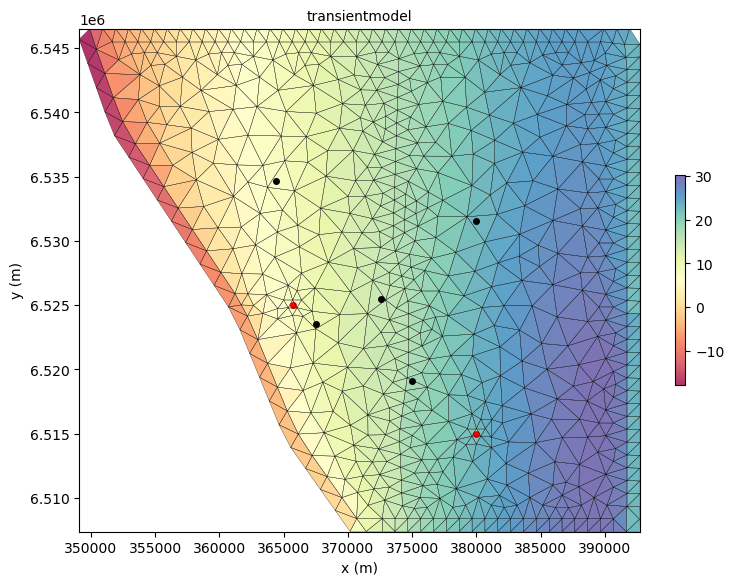

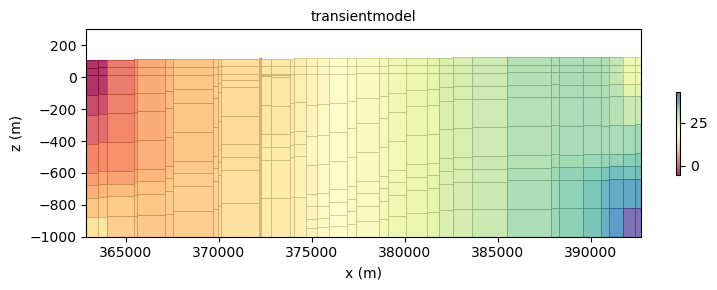

In [ ]:
watertable = fm2.get_watertable(geomodel, fm2.head)
fm2.plot_watertable(spatial, mesh, geomodel, fm2, watertable,)#, extent, vmin, vmax
fm2.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)